# Segmentation -> Kalman Filtering

### Workflow
- Splitting dataframe into separate dataframes when two traces are >60s apart 
- Kalman filter the 'segments' separately
- Recombine into single dataframe @ end for plotting

### Conclusion
Segmenting by time leads to better results by eliminating 'hallucinations' in the data

(See below cells to qualitatively see plotted results)

In [5]:
import pandas as pd
from scripts.utils import filter_person_and_date
from scripts.KalmanFilter import kalman_filter
from scripts.TimeSegmentation import Segment

In [7]:
all_plt_data = pd.read_csv('../flask-app/static/data/all_plt_data.csv')

In [26]:
person179 = filter_person_and_date(all_plt_data, 179, '2008-11-09')
person179

,person,lat,long,zero,altitude,date_numb_days,date,time,cst_datetime,cst_weekday
1753949,179,40.087961,116.304268,0,492.0,39761.073264,2008-11-09,01:45:30,2008-11-09 09:45:30+08:00,6
1753950,179,40.087904,116.304239,0,491.0,39761.073287,2008-11-09,01:45:32,2008-11-09 09:45:32+08:00,6
1753951,179,40.087839,116.304208,0,491.0,39761.073310,2008-11-09,01:45:34,2008-11-09 09:45:34+08:00,6
1753952,179,40.087815,116.304182,0,491.0,39761.073333,2008-11-09,01:45:36,2008-11-09 09:45:36+08:00,6
1753953,179,40.087786,116.304200,0,491.0,39761.073356,2008-11-09,01:45:38,2008-11-09 09:45:38+08:00,6
...,...,...,...,...,...,...,...,...,...,...
1754403,179,40.050362,116.300541,0,299.0,39761.102870,2008-11-09,02:28:08,2008-11-09 10:28:08+08:00,6
1754404,179,40.050317,116.300575,0,304.0,39761.102894,2008-11-09,02:28:10,2008-11-09 10:28:10+08:00,6
1754405,179,40.050271,116.300609,0,303.0,39761.102917,2008-11-09,02:28:12,2008-11-09 10:28:12+08:00,6
1754406,179,40.050221,116.300636,0,303.0,39761.102940,2008-11-09,02:28:14,2008-11-09 10:28:14+08:00,6


In [21]:
segmented_179 = time_segmentation(person179, 60)
print(len(segmented_179))

segments = []
for i, df in enumerate(segmented_179):
    df = df.copy()  # Ensure that we are working with a copy
    kalman_df = kalman_filtering(df)
    kalman_df['segment'] = i  # Assign segment number
    segments.append(kalman_df)
    print(f"Segment {i} assigned with {len(kalman_df)} rows.")  # Debugging: Print number of rows in each segment
    print(kalman_df.head())  # Debugging: Print the head of the DataFrame

kalman_segment_179 = pd.concat(segments, ignore_index=True)
print(f"Unique segments in combined DataFrame: {kalman_segment_179['segment'].unique()}")  # Should show an array of unique segment numbers


Split indices: [0, 245, 263, 413, 458]
Segment 0: 245 rows
Segment 1: 18 rows
Segment 2: 150 rows
Segment 3: 45 rows
4
Segment 0 assigned with 245 rows.
   person        lat        long  zero  altitude  date_numb_days        date  \
0     179  40.087961  116.304268     0     492.0    39761.073264  2008-11-09   
1     179  40.087904  116.304239     0     491.0    39761.073287  2008-11-09   
2     179  40.087839  116.304208     0     491.0    39761.073310  2008-11-09   
3     179  40.087815  116.304182     0     491.0    39761.073333  2008-11-09   
4     179  40.087786  116.304200     0     491.0    39761.073356  2008-11-09   

       time              cst_datetime  cst_weekday  time_diff  lat_filtered  \
0  01:45:30 2008-11-09 09:45:30+08:00            6        NaN     40.087934   
1  01:45:32 2008-11-09 09:45:32+08:00            6        2.0     40.087897   
2  01:45:34 2008-11-09 09:45:34+08:00            6        2.0     40.087851   
3  01:45:36 2008-11-09 09:45:36+08:00            6

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

def get_viridis_colors(num_colors):
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
    return colors

def plot_segmented_data(data, title = ""):
    """ 
    Plot the different segments of the data as different colors using discrete color blocks
    """

    # Make a copy of the data
    data_copy = data.copy()

    # Convert 'time' column to datetime (if needed for other purposes)
    data_copy['time_datetime'] = pd.to_datetime(data_copy['time'], format='%H:%M:%S')

    plt.figure(figsize=(10, 6))

    # Define a list of colors for the segments
    n_segments = len(data_copy['segment'].unique())
    colors = get_viridis_colors(n_segments)
    
    # Get unique segments
    segments = data_copy['segment'].unique()

    # Plot each segment with a different color
    for i, segment in enumerate(segments):
        segment_data = data_copy[data_copy['segment'] == segment]
        plt.scatter(segment_data['long'], 
                    segment_data['lat'], 
                    color=colors[i % len(colors)],  # Cycle through colors if there are more segments than colors
                    label=f'Segment {segment}')
        
    sc_filter = plt.scatter(data_copy['long_filtered'], 
                            data_copy['lat_filtered'], 
                            s=10,
                            color='#e05343',
                            label='Smoothed data')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.ticklabel_format(useOffset=False, axis='x')  # Show raw longitude, not offset
    plt.legend()
    if title == "":
        plt.title(f'Person_{data_copy["person"].iloc[0]} location on {data_copy["date"].iloc[0]}')
    else:
        plt.title(title)
    plt.show()

def plot_kalman_filtered_data(data):
    """ 
    Plot the observed vs. Kalman filtered lat/long data for a single person on a single day
    @param: 
        data: pd.DataFrame with 'lat', 'long', 'lat_filtered', and 'long_filtered' columns
        title: str, title of the plot
    @return: displays the plot, inline
    """

    # Make a copy of the data
    data_copy = data.copy()

    # Convert 'time' column to datetime
    data_copy['time_datetime'] = pd.to_datetime(data_copy['time'], format='%H:%M:%S')

    # Convert 'time' column to the total number of seconds past midnight
    data_copy['norm_time'] = data_copy['time_datetime'].dt.hour * 3600 + data_copy['time_datetime'].dt.minute * 60 + data_copy['time_datetime'].dt.second

    # Normalize the time for the color mapping
    norm_data = Normalize(data_copy['norm_time'].min(), data_copy['norm_time'].max())

    plt.figure(figsize=(10, 6))

    sc = plt.scatter(data_copy['long'], 
                    data_copy['lat'], 
                    c=data_copy['norm_time'], 
                    label='Observed data',
                    cmap='viridis', 
                    norm=norm_data)
    plt.colorbar(sc, label='Seconds since midnight')

    # plt.plot(data_copy['lat_filtered'], data_copy['long_filtered'], color='#e05343', label='Smoothed data', linewidth=3)
    sc_filter = plt.scatter(data_copy['long_filtered'], 
                            data_copy['lat_filtered'], 
                            # c=data_copy['norm_time'],
                            s=10,
                            color='#e05343',
                            # norm=norm_data,
                            label='Smoothed data')
    # plt.colorbar(sc_filter)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.ticklabel_format(useOffset=False, axis='x') # show raw long, not 0.022 or whatever
    plt.legend()
    plt.title(f'Kalman filtered: Person_{data_copy["person"].iloc[0]} location on {data_copy["date"].iloc[0]}')
    plt.show()

## Kalman filtering without segmentation

Produces hallucinations between chunks of GPS data

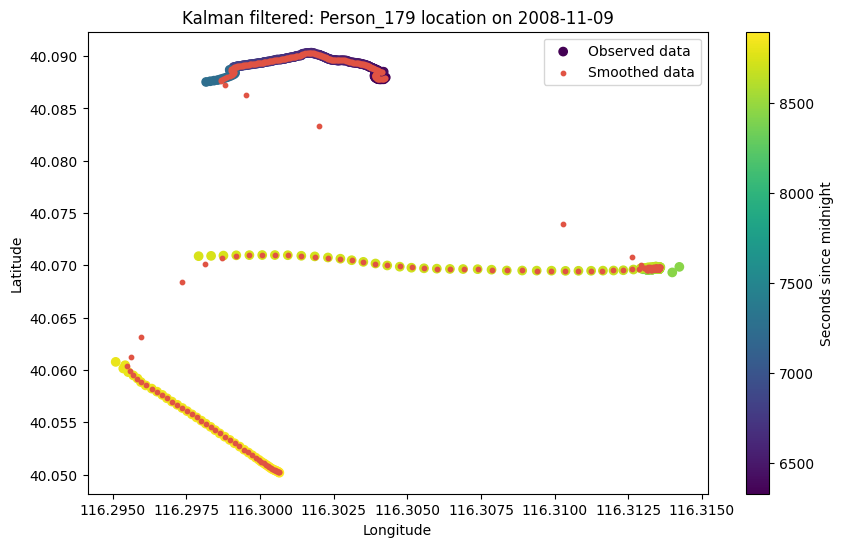

In [27]:
# No segmentation filtering
person179 = filter_person_and_date(all_plt_data, 179, '2008-11-09')
kalman_179 = kalman_filtering(person179)
plot_kalman_filtered_data(kalman_179)

## Kalman filtering with 60sec segmentation

Eliminates all hallucinations!

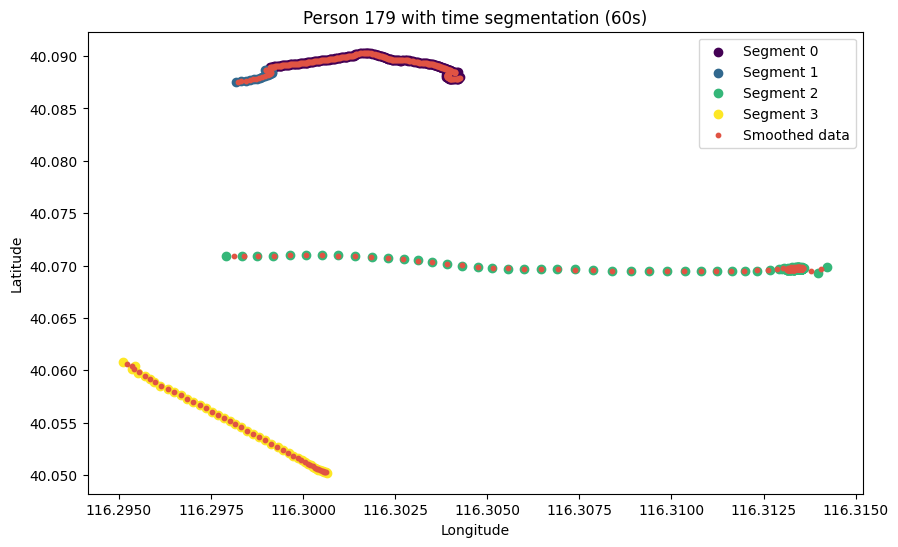

In [23]:
plot_segmented_data(kalman_segment_179, f'Person 179 with time segmentation (60s)')

In [31]:
person161 = filter_person_and_date(all_plt_data, 161, '2007-04-16')
segmented_161 = time_segmentation(person161, 60)

def kalman_with_segment(segment_df_list):
    segments = []
    for i, df in enumerate(segment_df_list):
        df = df.copy()  # Ensure that we are working with a copy
        kalman_df = kalman_filtering(df)
        kalman_df['segment'] = i  # Assign segment number
        segments.append(kalman_df)
        print(f"Segment {i} assigned with {len(kalman_df)} rows.")  # Debugging: Print number of rows in each segment
        print(kalman_df.head())  # Debugging: Print the head of the DataFrame

    kalman_segment = pd.concat(segments, ignore_index=True)
    print(f"Unique segments in combined DataFrame: {kalman_segment['segment'].unique()}")  # Should show an array of unique segment numbers
    return kalman_segment

kalman_segment_161 = kalman_with_segment(segmented_161)

Split indices: [0, 8, 20, 22, 25, 67]
Segment 0: 8 rows
Segment 1: 12 rows
Segment 2: 2 rows
Segment 3: 3 rows
Segment 4: 42 rows
Segment 0 assigned with 8 rows.
   person        lat        long  zero    altitude  date_numb_days  \
0     161  39.975350  116.328300     0  124.671916    39188.543657   
1     161  39.975417  116.328100     0  124.671916    39188.543819   
2     161  39.975400  116.327900     0  124.671916    39188.543958   
3     161  39.975133  116.327883     0  124.671916    39188.544178   
4     161  39.975000  116.327733     0  124.671916    39188.544282   

         date      time              cst_datetime  cst_weekday  time_diff  \
0  2007-04-16  13:02:52 2007-04-16 21:02:52+08:00            0        NaN   
1  2007-04-16  13:03:06 2007-04-16 21:03:06+08:00            0       14.0   
2  2007-04-16  13:03:18 2007-04-16 21:03:18+08:00            0       12.0   
3  2007-04-16  13:03:37 2007-04-16 21:03:37+08:00            0       19.0   
4  2007-04-16  13:03:46 2007-04-

## Segmentation also reduces hallucinations in sparse data

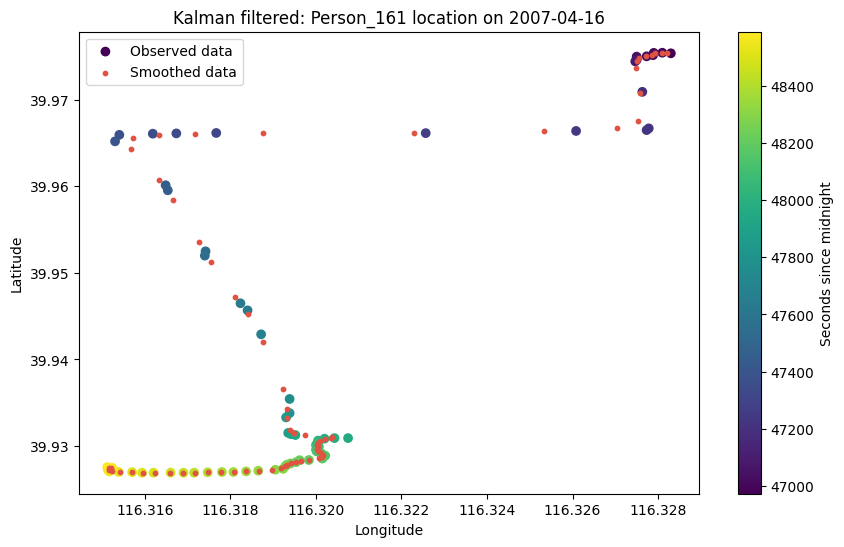

In [34]:
# Person 161
person161 = filter_person_and_date(all_plt_data, 161, '2007-04-16')
kalman161 = kalman_filtering(person161)
plot_kalman_filtered_data(kalman161)

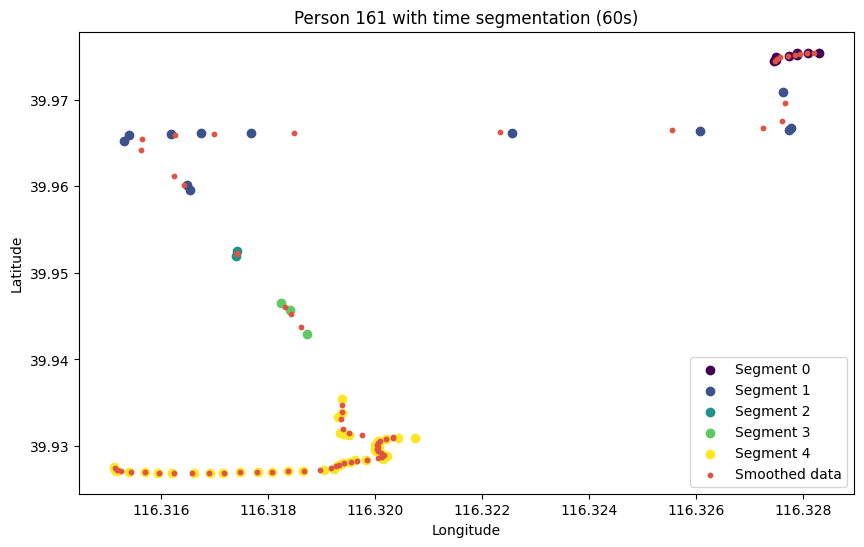

In [35]:
plot_segmented_data(kalman_segment_161, f'Person 161 with time segmentation (60s)')

In [10]:
from scripts.utils import filter_person_and_date
from scripts.KalmanFilter import kalman_filter
from scripts.PlotMap import PlotMap
from scripts.TimeSegmentation import Segment

person_df = filter_person_and_date(all_plt_data, 179, '2008-11-09')
# kalman_df = kalman_filter(person_df)
segment_df = Segment.segment_df(person_df, time_cutoff=60)
# ksegment_df = Segment.kalman_filter_segments(segment_df)

pm = PlotMap(person_df)

pm.full_polyline(person_df, 'original')
# pm.full_polyline(kalman_df, 'kalman')

pm.segment_polyline(ksegment_df, 'kalman')

pm.circles(person_df, 'original')
# pm.circles(kalman_df, 'kalman') # with no time segmentation
pm.circles(ksegment_df, 'kalman') # with time segmentation

pm.show()

Split indices: [0, 245, 263, 413, 458]
